#### Groq offers a generous free tier as per below image

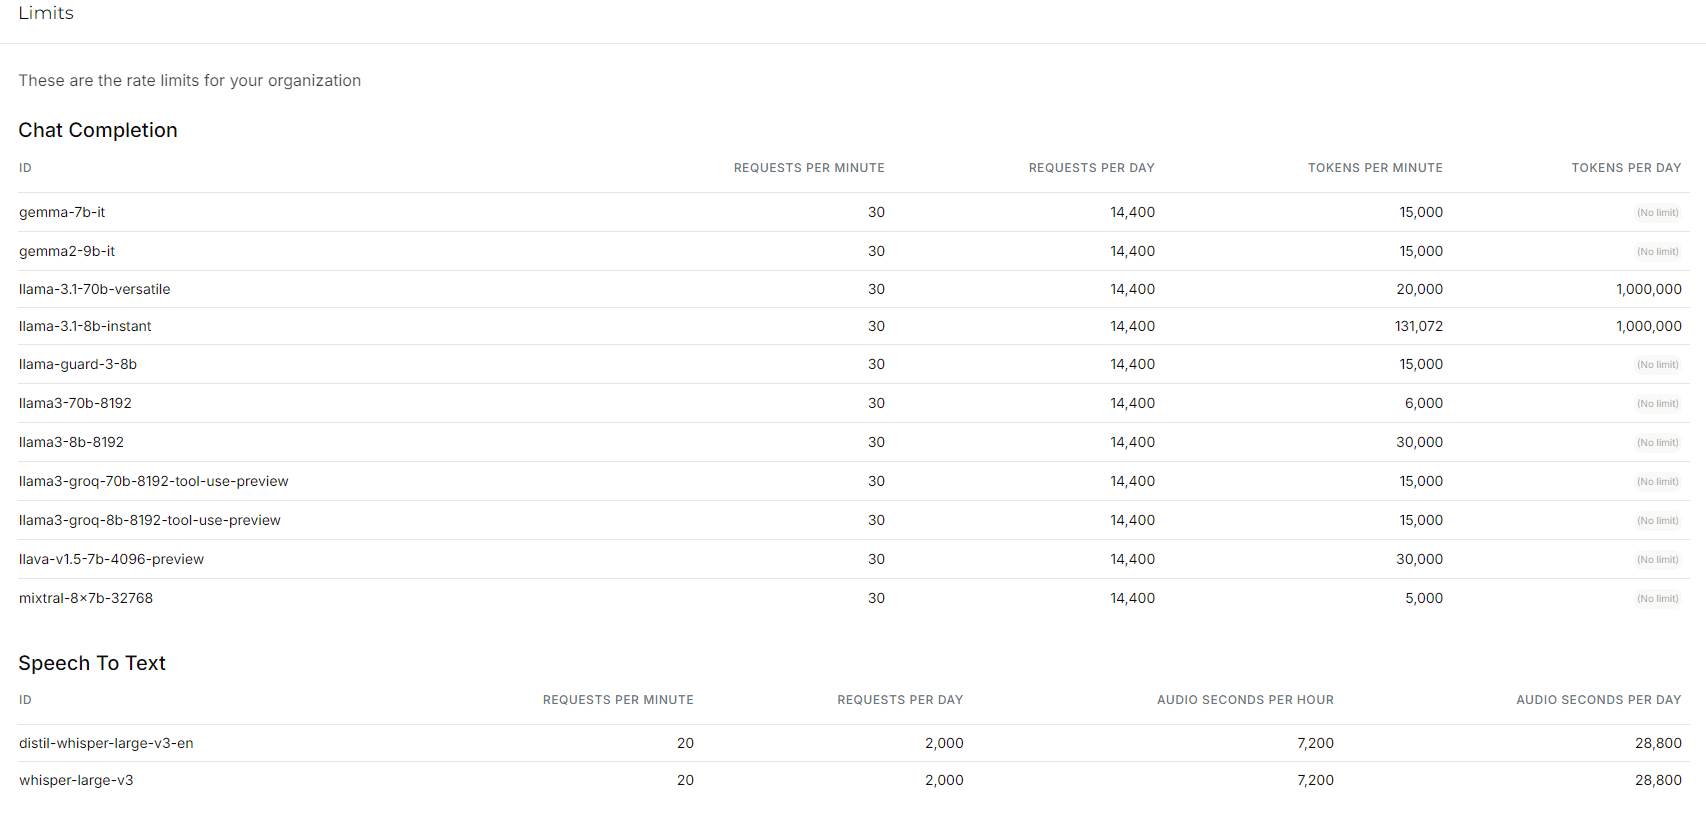

### Steps to get started

- Create a account on https://console.groq.com/
- Go to your https://console.groq.com/keys
- Create a new API key and save it in `.env` file as `GROQ_API_KEY`

In [2]:
%pip install -q groq

Note: you may need to restart the kernel to use updated packages.


Other models supported are as per above rate limits

In [3]:
import os

from groq import Groq

groq_client = client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# replace this with any other model as per top image
model = "llama3-8b-8192"

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": "Explain the importance of fast language models",
        }
    ],
    model=model,
)



In [5]:
chat_completion.__dict__

{'id': 'chatcmpl-c0224a10-4a58-4eed-bd44-c304c1c719ba',
 'choices': [Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Fast language models have become increasingly important in recent years due to their applications in various fields, including but not limited to:\n\n1. **Natural Language Processing (NLP)**: Fast language models enable efficient processing of large amounts of text data, allowing for tasks such as text classification, sentiment analysis, and language translation to be performed in real-time.\n2. **Sentiment Analysis**: Fast language models can quickly analyze customer feedback, sentiment, and opinions extracted from text data, helping businesses respond promptly to customer concerns and improve their brand reputation.\n3. **Chatbots and Conversational Interfaces**: Fast language models power chatbots and virtual assistants, enabling them to respond intelligently and accurately to user inputs, providing a more seamless user expe

The response is in markdown format

In [10]:
print(chat_completion.choices[0].message.content)

Fast language models have become increasingly important in recent years due to their applications in various fields, including but not limited to:

1. **Natural Language Processing (NLP)**: Fast language models enable efficient processing of large amounts of text data, allowing for tasks such as text classification, sentiment analysis, and language translation to be performed in real-time.
2. **Sentiment Analysis**: Fast language models can quickly analyze customer feedback, sentiment, and opinions extracted from text data, helping businesses respond promptly to customer concerns and improve their brand reputation.
3. **Chatbots and Conversational Interfaces**: Fast language models power chatbots and virtual assistants, enabling them to respond intelligently and accurately to user inputs, providing a more seamless user experience.
4. **Language Translation**: Fast language models can quickly translate text between languages, facilitating communication between people speaking different 

### Tool calling with llama 3 70b 8192

In [20]:
from groq import Groq
import json

client = Groq()
intermediate_response = None
MODEL = 'llama3-groq-70b-8192-tool-use-preview'

def calculate(expression):
    """Evaluate a mathematical expression"""
    try:
        result = eval(expression)
        return json.dumps({"result": result})
    except:
        return json.dumps({"error": "Invalid expression"})

def run_conversation(user_prompt):
    messages=[
        {
            "role": "system",
            "content": "You are a calculator assistant. Use the calculate function to perform mathematical operations and provide the results."
        },
        {
            "role": "user",
            "content": user_prompt,
        }
    ]
    tools = [
        {
            "type": "function",
            "function": {
                "name": "calculate",
                "description": "Evaluate a mathematical expression",
                "parameters": {
                    "type": "object",
                    "properties": {
                        "expression": {
                            "type": "string",
                            "description": "The mathematical expression to evaluate",
                        }
                    },
                    "required": ["expression"],
                },
            },
        }
    ]
    response = client.chat.completions.create(
        model=MODEL,
        messages=messages,
        tools=tools,
        tool_choice="auto",
    )

    response_message = response.choices[0].message
    intermediate_response = response_message
    print(intermediate_response)
    tool_calls = response_message.tool_calls
    if tool_calls:
        available_functions = {
            "calculate": calculate,
        }
        messages.append(response_message)
        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions[function_name]
            function_args = json.loads(tool_call.function.arguments)
            function_response = function_to_call(
                expression=function_args.get("expression")
            )
            messages.append(
                {
                    "tool_call_id": tool_call.id,
                    "role": "tool",
                    "name": function_name,
                    "content": function_response,
                }
            )
        second_response = client.chat.completions.create(
            model=MODEL,
            messages=messages
        )
        return second_response.choices[0].message.content

user_prompt = "What is 8 raise to power 4"
print(run_conversation(user_prompt))

ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_3752', function=Function(arguments='{"expression": "8^4"}', name='calculate'), type='function')])
The result of 8 raised to the power of 4 is 4096.


The above `ChatCompletionMessage` has empty content but `tool_calls` has important attributes of `function=Function(arguments='{"expression": "8^4"}` and name of function `calculate`

This intermediate response is then passed to `calculate()` via line - 

```py
function_response = function_to_call(
                expression=function_args.get("expression")
            )
```

which corresponds to `function_response = calculate("8^4")` and then inside this function it goes through `eval()` which does this operation and returns the response

This `function_response` is appended to the `messages` array to be provided as context that the tool call gave this answer after compute and final answer is computed and stored inside `second_response` where `messages` array is passed, now with tool call result giving the answer => The result of 8 raised to the power of 4 is 4096.